# Setup

In [78]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split

from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
import statsmodels.tsa.api as tsa
import warnings
#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)

# set random seed
SEED = 321
np.random.seed(SEED)

warnings.filterwarnings('ignore')

In [79]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    
### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags == None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df["mean"].plot(ax=ax, color="green", label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(
        forecast_df.index,
        forecast_df["mean_ci_lower"],
        forecast_df["mean_ci_upper"],
        color="green",
        alpha=0.3,
        lw=2,
    )

    # set the title and add legend
    ax.set_title(title)
    ax.legend()

    return fig, ax
# Custom function for Ad Fuller Test

In [80]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, icbest) = tsa.adfuller(ts, **kwargs)
    
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {
        "Test Statistic": test_stat,
        "# of Lags Used": nlags,
        "# of Observations": nobs,
        "p-value": round(pval, 6),
        "alpha": alpha,
        "sig/stationary?": pval < alpha,
    }
    
    return pd.DataFrame(adfuller_results, index=[label])

In [81]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [82]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                  acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                  seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict(ls=":", lw=1, zorder=0, color="red")

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="ACF")
        for lag in sig_acf_lags:
            axes[0].axvline(lag, label="sig", **sig_vline_kwargs)

    # PACF
    tsa.graphics.plot_pacf(ts, ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="PACF")
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label="sig", **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags // m

        # Seasonal Lines style
        seas_vline_kwargs = dict(ls="--", lw=1, alpha=0.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons + 1):
            axes[0].axvline(m * i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m * i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

In [83]:
# !ls

In [84]:
path = '../combined_csv.csv'
df = pd.read_csv(path)

In [85]:
df.head()

,Date,Primary Type
0,2001-01-01 01:00:00,BATTERY
1,2001-01-01 13:00:00,BATTERY
2,2001-01-01 13:00:00,GAMBLING
3,2001-01-01 01:00:00,CRIMINAL DAMAGE
4,2001-01-01 01:00:00,BATTERY


In [86]:
# pd.to_datetime(df['Date'].head(), format=)

In [87]:
fmt_string = '%Y-%m-%d %H:%M:%S'

In [88]:
df['Date'] = pd.to_datetime(df['Date'], format=fmt_string)

In [89]:
try:
    df = df.set_index('Date')
except KeyError as e:
    pass
df.head()

,Primary Type
Date,
2001-01-01 01:00:00,BATTERY
2001-01-01 13:00:00,BATTERY
2001-01-01 13:00:00,GAMBLING
2001-01-01 01:00:00,CRIMINAL DAMAGE
2001-01-01 01:00:00,BATTERY


# Theft and narcotics

In [90]:
theft_df = df[df['Primary Type'] == 'THEFT']
theft_ts = theft_df.resample('M').size()

In [91]:
narcotics_df = df[df['Primary Type'] == 'NARCOTICS']
narcotics_ts = narcotics_df.resample('M').size()

# Theft

### ACF/PACF

In [92]:
theft_ts.isnull()

Date
2001-01-31    False
2001-02-28    False
2001-03-31    False
2001-04-30    False
2001-05-31    False
              ...  
2022-08-31    False
2022-09-30    False
2022-10-31    False
2022-11-30    False
2022-12-31    False
Freq: M, Length: 264, dtype: bool

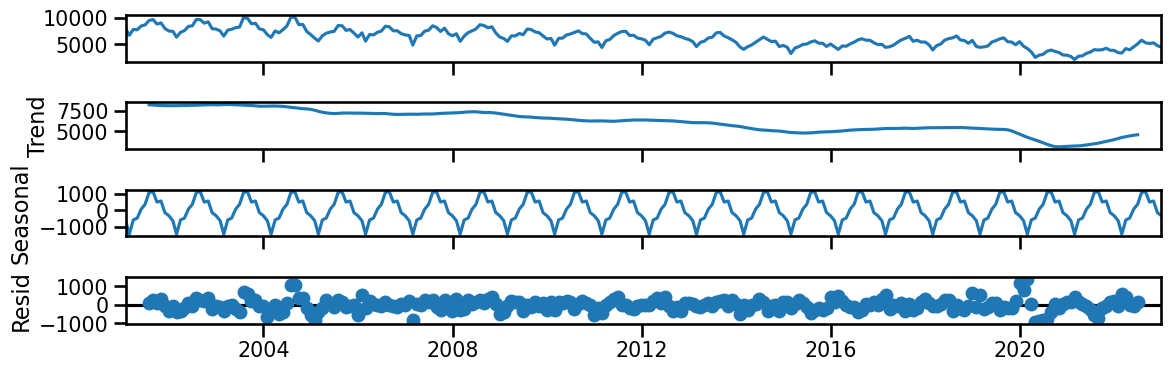

In [93]:
decomp = tsa.seasonal_decompose(theft_ts)
decomp.plot()
plt.tight_layout()

In [94]:
decomp.seasonal.max() - decomp.seasonal.min()

2549.988095238095

In [95]:
theft_ts.max() - theft_ts.min()

7948

In [96]:
theft_ts.diff()

Date
2001-01-31       NaN
2001-02-28   -1198.0
2001-03-31    1097.0
2001-04-30     -64.0
2001-05-31     718.0
               ...  
2022-08-31    -490.0
2022-09-30    -127.0
2022-10-31     125.0
2022-11-30    -525.0
2022-12-31    -304.0
Freq: M, Length: 264, dtype: float64

In [97]:
get_adfuller_results(theft_ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.393935,13,250,0.58518,0.05,False


In [98]:
ndiffs(theft_ts)

1

In [99]:
theft_ts.index.freq

<MonthEnd>

In [100]:
theft_ts_diff1 = theft_ts.diff().dropna()

In [101]:
get_adfuller_results(theft_ts.diff().dropna())

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-3.953728,12,250,0.001673,0.05,True


In [102]:
nsdiffs(theft_ts, m=12)

0

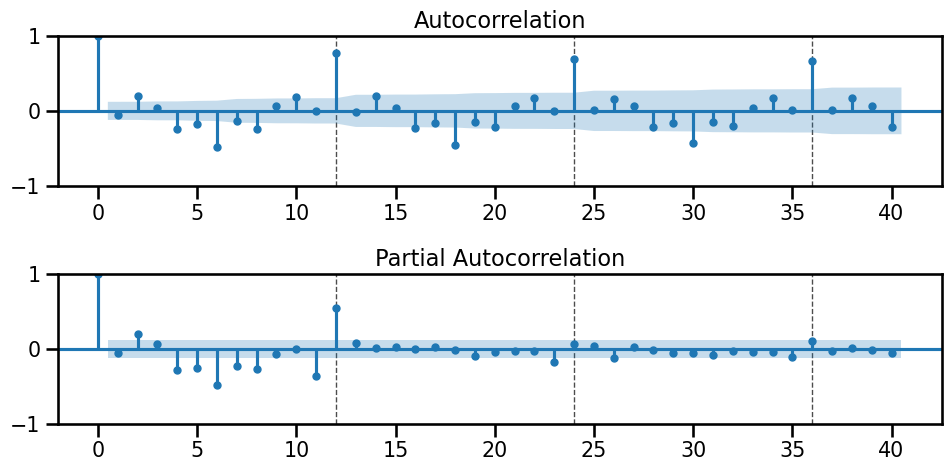

In [103]:
plot_acf_pacf(theft_ts_diff1, m=12, annotate_seas=True);

Both plots have a dramatic drop after the first lag.

Seasonally, it looks like a gradual decrease in the ACF and a sharp drop in the PACF after lag 2.

In [104]:
p=1
d=1
q=1

P=1
D=0
Q=1

m=12

### Manual Models

In [105]:
train, test = train_test_split(theft_ts, test_size=6)

In [106]:
theft_model_manual = tsa.ARIMA(train, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

In [107]:
theft_model_manual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1874.390
Date:                          Sun, 28 Jan 2024   AIC                           3758.779
Time:                                  14:36:50   BIC                           3776.524
Sample:                              01-31-2001   HQIC                          3765.915
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      1.380      0.724      0.469      -1.706       3.704
ma.L1         -0.9989      1.393     -0.717      0.473      -3.730       1.732
ar.S.L12       0.9712      0.009    112.660      0.000       0.954       0.988
ma.S.L12      -0.6596      0.044    -14.868      0.000      -0.747      -0.573
sigma2      1.102e+05   7479.758     14.731      0.000    9.55e+04    1.25e+05
===================================================================================
Ljung-Box (L1) (Q):                  11.04   Jarque-Bera (JB):                12.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.25
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [108]:
theft_mod_manual_preds = theft_model_manual.get_forecast(6).summary_frame()

In [109]:
regression_metrics_ts(test, theft_mod_manual_preds['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 239.602
- MSE = 85,143.479
- RMSE = 291.794
- R^2 = 0.518
- MAPE = 4.88%


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

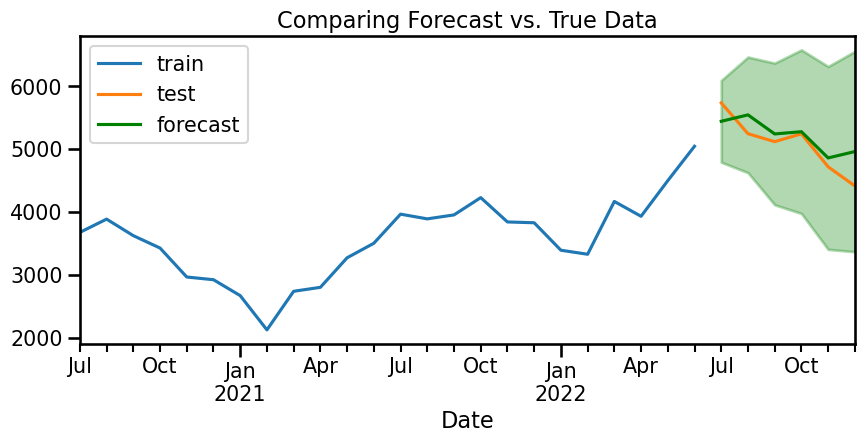

In [110]:
plot_forecast(train, test, theft_mod_manual_preds, n_train_lags=24)

### Auto ARIMA

In [111]:
theft_auto_model = pm.auto_arima(
    train,
    seasonal=True,  # True or False
    m=m,  # if seasonal
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4050.524, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3791.710, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3914.631, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4048.603, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4050.805, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3774.214, Time=0.45 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3747.772, Time=1.06 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3743.960, Time=0.59 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3913.736, Time=0.20 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3742.904, Time=0.98 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3870.719, Time=0.47 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3754.859, Time=0.84 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

In [112]:
theft_model_auto = tsa.ARIMA(train, order=(1,1,0), seasonal_order=(1,0,2,12)).fit()

In [113]:
theft_preds2 = theft_model_auto.get_forecast(len(test)).summary_frame()

In [114]:
regression_metrics_ts(test, theft_preds2['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 211.161
- MSE = 72,806.630
- RMSE = 269.827
- R^2 = 0.587
- MAPE = 4.27%


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

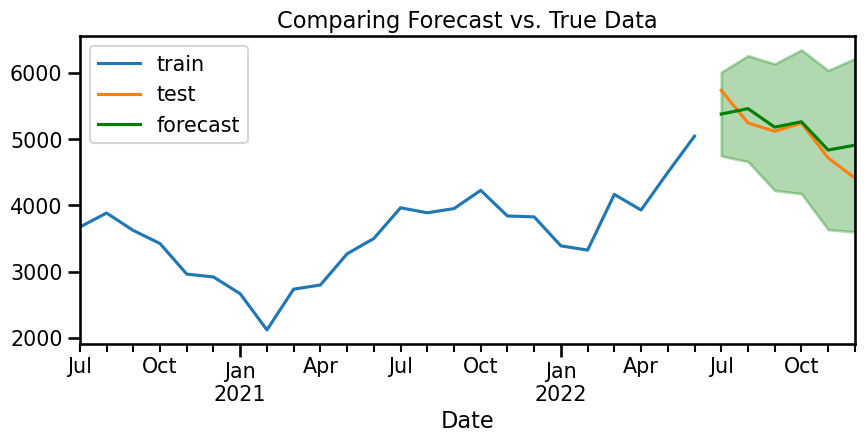

In [115]:
plot_forecast(train, test, theft_preds2, n_train_lags=24)

### Select final model & justify

  * The auto model, because it performed slightly better on all metrics.

In [116]:
final_model_theft = tsa.ARIMA(theft_ts, order=(1,1,0), seasonal_order=(1,0,2,12)).fit()
final_forecast_theft_predictions = final_model_theft.get_forecast(steps=len(test)).summary_frame()
final_forecast_theft_predictions

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-31,4031.377573,321.600839,3401.051512,4661.703634
2023-02-28,3682.882994,406.865671,2885.440932,4480.325055
2023-03-31,4195.646637,485.835925,3243.425722,5147.867552
2023-04-30,4052.230405,551.906011,2970.514501,5133.946309
2023-05-31,4564.098416,611.225543,3366.118365,5762.078467
2023-06-30,4920.800029,665.203413,3617.025297,6224.574761


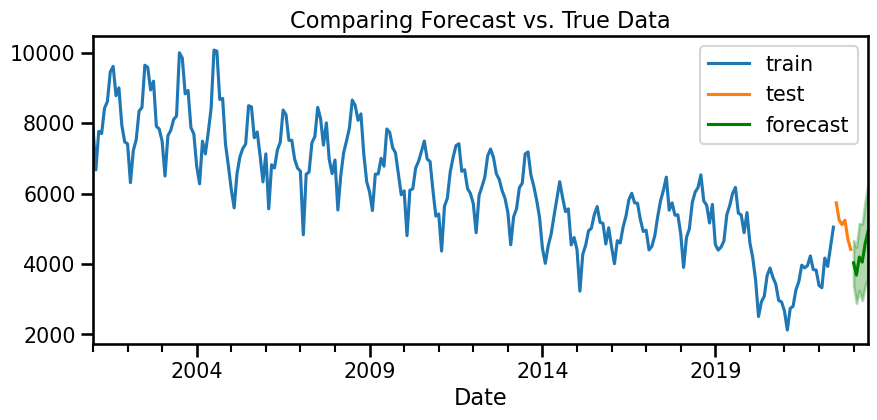

In [117]:
plot_forecast(train, test, final_forecast_theft_predictions);

In [176]:
# final_forecast_theft_predictions.iloc[0]
final_forecast_theft_predictions.iloc[-1]

y
mean             4920.800029
mean_se           665.203413
mean_ci_lower    3617.025297
mean_ci_upper    6224.574761
Name: 2023-06-30 00:00:00, dtype: float64

# Narcotics

### ACF/PACF

In [118]:
narcotics_ts.isnull()

Date
2001-01-31    False
2001-02-28    False
2001-03-31    False
2001-04-30    False
2001-05-31    False
              ...  
2022-08-31    False
2022-09-30    False
2022-10-31    False
2022-11-30    False
2022-12-31    False
Freq: M, Length: 264, dtype: bool

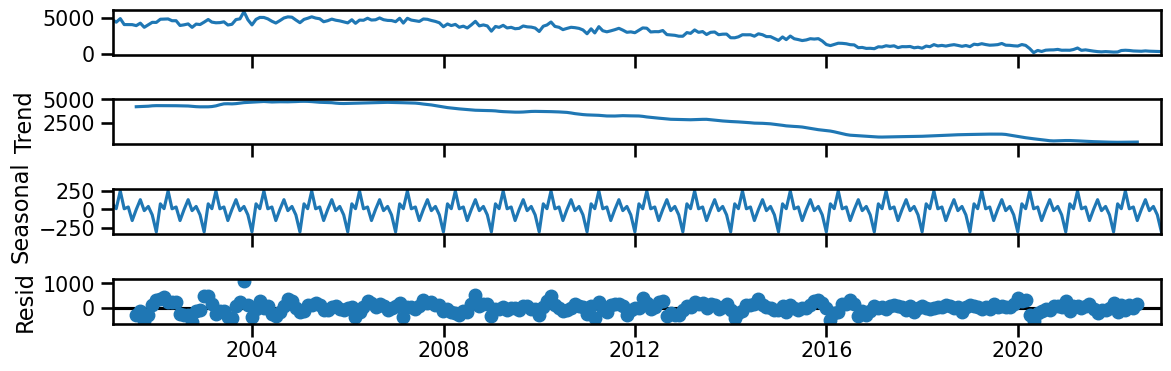

In [119]:
decomp = tsa.seasonal_decompose(narcotics_ts)
decomp.plot()
plt.tight_layout()

In [120]:
(decomp.seasonal.max() - decomp.seasonal.min()) / (narcotics_ts.values.max() - narcotics_ts.values.min()) * 100

9.760062006605787

The seasonal component is pretty okay

In [121]:
get_adfuller_results(narcotics_ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.265472,12,251,0.975704,0.05,False


In [122]:
ndiffs(narcotics_ts)

1

In [123]:
narcotics_ts_diff = narcotics_ts.diff().dropna()

In [124]:
get_adfuller_results(narcotics_ts.diff().dropna())

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-5.393766,11,251,0.000003,0.05,True


In [125]:
nsdiffs(narcotics_ts, 12)

0

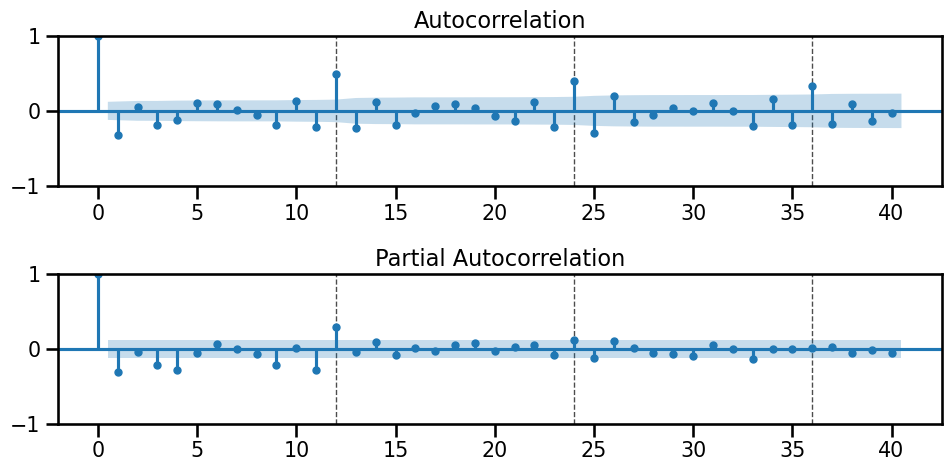

In [126]:
plot_acf_pacf(narcotics_ts_diff, m=12, annotate_seas=True);

Looks like a sharp drop in ACF & PACF after lag 1.and

The ACF's seasonal lags decline gradually, on the PACF it's hard to tell, so let's say no sharp drop for now.

In [127]:
train, test = train_test_split(narcotics_ts, test_size=6)

### Manual Models

In [128]:
D = nsdiffs(narcotics_ts, m =12)

In [129]:
# set model params
p = 1
d = 1
q = 1

P = 1
D = 0
Q = 0

m = 12

In [130]:
narcotics_model1 = tsa.ARIMA(train, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

In [131]:
narcotics_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, [], 12)   Log Likelihood               -1778.793
Date:                           Sun, 28 Jan 2024   AIC                           3565.587
Time:                                   14:37:18   BIC                           3579.783
Sample:                               01-31-2001   HQIC                          3571.296
                                    - 06-30-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5096      0.082      6.245      0.000       0.350       0.669
ma.L1         -0.8290      0.057    -14.431      0.000      -0.942      -0.716
ar.S.L12       0.4893      0.049      9.889      0.000       0.392       0.586
sigma2      5.968e+04   4037.217     14.783      0.000    5.18e+04    6.76e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                33.71
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [132]:
narcotics_mod1_preds = narcotics_model1.get_forecast(6).summary_frame()

In [133]:
regression_metrics_ts(test, narcotics_mod1_preds['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 73.631
- MSE = 6,293.879
- RMSE = 79.334
- R^2 = -5.779
- MAPE = 19.87%


Wow that's bad.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

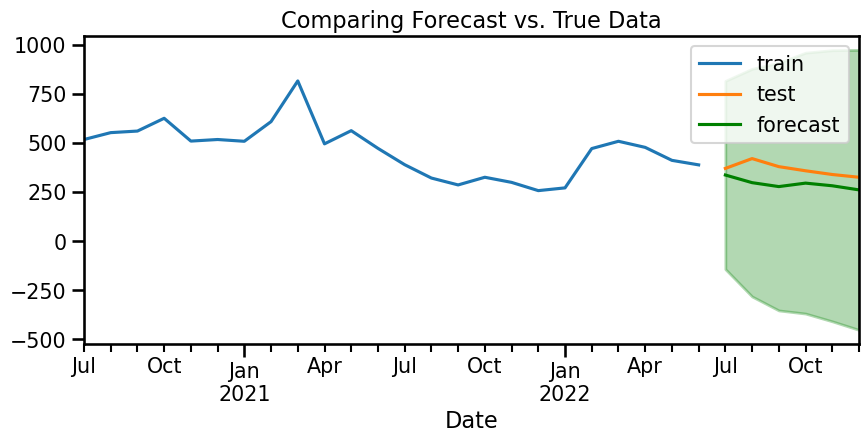

In [134]:
plot_forecast(train, test, narcotics_mod1_preds, n_train_lags=24)

### Auto ARIMA

In [135]:
pm.auto_arima(train, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3669.016, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3583.957, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3595.909, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3667.813, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3643.189, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3577.354, Time=0.64 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3559.635, Time=1.10 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3559.679, Time=0.50 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3559.353, Time=1.02 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3589.825, Time=0.44 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3602.922, Time=0.20 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3566.698, Time=0.97 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

ARIMA(order=(4, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [136]:
narcotics_model_auto = tsa.ARIMA(train, order=(1,1,0), seasonal_order=(2,0,0,12)).fit()

In [137]:
narcotics_preds_auto = narcotics_model_auto.get_forecast(len(test)).summary_frame()

In [138]:
regression_metrics_ts(test, narcotics_preds_auto['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 22.089
- MSE = 763.641
- RMSE = 27.634
- R^2 = 0.178
- MAPE = 5.76%


(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

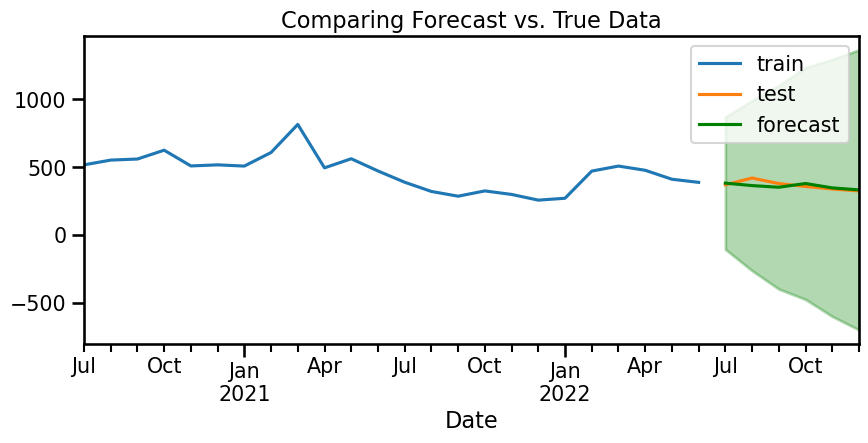

In [139]:
plot_forecast(train, test, narcotics_preds_auto, n_train_lags=24)

In [140]:
# # manually trying things

# p = 1
# d = 1
# q = 1

# P = 2
# D = 0
# Q = 0

# narcotics_model_auto = tsa.ARIMA(train, order=(1,2,1), seasonal_order=(2,0,0,12)).fit()
# narcotics_preds_auto = narcotics_model_auto.get_forecast(len(test)).summary_frame()
# regression_metrics_ts(test, narcotics_preds_auto['mean'])

Neither is any good at all

## Let's try this

In [153]:
# %%timeit

# find potential model orders that at least have a positive R^2
# possible_orders = []

# commenting out this huge loop for testing

# for p in range(3):
#     for d in range(1,2):
#         for q in range(3):
#             for P in range(3):
#                 for D in range(0,1):
#                     for Q in range(3):
#                         model = tsa.ARIMA(train, order=(p,d,q), seasonal_order=(P, D, Q, 12)).fit();
#                         forecast = model.get_forecast(steps=len(test)).summary_frame();
#                         metrics = regression_metrics_ts(test, forecast['mean'], output_dict=True, verbose=False);
#                         if metrics['R^2'] > 0:
#                             k = str((p, d, q))
#                             possible_orders.append({
#                                 k: metrics['R^2'],
#                                 'seasonal': (P, D, Q)
#                             })
possible_orders = [{'(2, 1, 3)': 0.7223418165691149, 'seasonal': (2, 0, 0)},
 {'(3, 1, 0)': 0.3900764600275999, 'seasonal': (2, 0, 0)},
 {'(1, 1, 0)': 0.17752931266429084, 'seasonal': (2, 0, 0)},
 {'(0, 1, 1)': 0.15541169323576698, 'seasonal': (2, 0, 0)},
 {'(0, 1, 0)': 0.07300173640832108, 'seasonal': (2, 0, 0)}]

In [154]:
(p, d, q) = (1, 1, 0)

(P, D, Q) = (2, 0, 0)

In [155]:
narcotics_model_auto = tsa.ARIMA(train, order=(1,1,0), seasonal_order=(2,0,0,12)).fit()
narcotics_preds_auto = narcotics_model_auto.get_forecast(len(test)).summary_frame()
regression_metrics_ts(test, narcotics_preds_auto['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 22.089
- MSE = 763.641
- RMSE = 27.634
- R^2 = 0.178
- MAPE = 5.76%


* That's still pretty bad. What if we keep the seasonal order constant and try some more?

In [156]:
possible_orders = []

import warnings

for p in range(5):
    for q in range(5):
        model = tsa.ARIMA(train, order=(p,1,q), seasonal_order=(2, 0, 0, 12)).fit();
        forecast = model.get_forecast(steps=len(test)).summary_frame();
        metrics = regression_metrics_ts(test, forecast['mean'], output_dict=True, verbose=False);
        if metrics['R^2'] > 0:
            k = str((p, 1, q))
            possible_orders.append({
                k: metrics['R^2'],
                'seasonal': (P, D, Q)
            })
                        

In [157]:
possible_orders.sort(key=lambda x: list(x.values())[0], reverse=True)
possible_orders

[{'(2, 1, 3)': 0.7223418165691149, 'seasonal': (2, 0, 0)},
 {'(3, 1, 0)': 0.3900764600275999, 'seasonal': (2, 0, 0)},
 {'(1, 1, 0)': 0.17752931266429084, 'seasonal': (2, 0, 0)},
 {'(0, 1, 1)': 0.15541169323576698, 'seasonal': (2, 0, 0)},
 {'(0, 1, 0)': 0.07300173640832108, 'seasonal': (2, 0, 0)}]

* Now we're getting somewhere!

In [158]:
orders_to_try = [list(order.keys()) for order in possible_orders]

In [159]:
for ord in orders_to_try:
    order = ord[0]
    order = eval(order)
    model = tsa.ARIMA(train, order=order, seasonal_order=(2,0,0,12)).fit()
    forecast = model.get_forecast(steps=len(test)).summary_frame()
    print(order)
    regression_metrics_ts(test, forecast['mean'], output_dict=True)

(2, 1, 3)
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 14.056
- MSE = 257.798
- RMSE = 16.056
- R^2 = 0.722
- MAPE = 3.97%
(3, 1, 0)
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 21.123
- MSE = 566.297
- RMSE = 23.797
- R^2 = 0.390
- MAPE = 5.69%
(1, 1, 0)
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 22.089
- MSE = 763.641
- RMSE = 27.634
- R^2 = 0.178
- MAPE = 5.76%
(0, 1, 1)
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 22.123
- MSE = 784.177
- RMSE = 28.003
- R^2 = 0.155
- MAPE = 5.75%
(0, 1, 0)
------------------------------------------------------------
Regression Me

### Select final model & justify

(2, 1, 3) Definitely has the best metrics of all the orders we've tried

In [160]:
order = (2, 1, 3)

In [161]:
final_model_narcotics = tsa.ARIMA(narcotics_ts, order=order, seasonal_order=(2,0,0,12)).fit()
final_forecast_narcotics = final_model_narcotics.get_forecast(steps=len(test)).summary_frame()
final_forecast_narcotics

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-31,360.567065,243.039695,-115.781983,836.916113
2023-02-28,417.958113,293.025974,-156.362242,992.278469
2023-03-31,446.728005,334.603071,-209.081963,1102.537973
2023-04-30,408.114661,357.190885,-291.966610,1108.195931
2023-05-31,417.259688,376.092958,-319.868965,1154.388340
2023-06-30,376.668680,403.860703,-414.883751,1168.221112


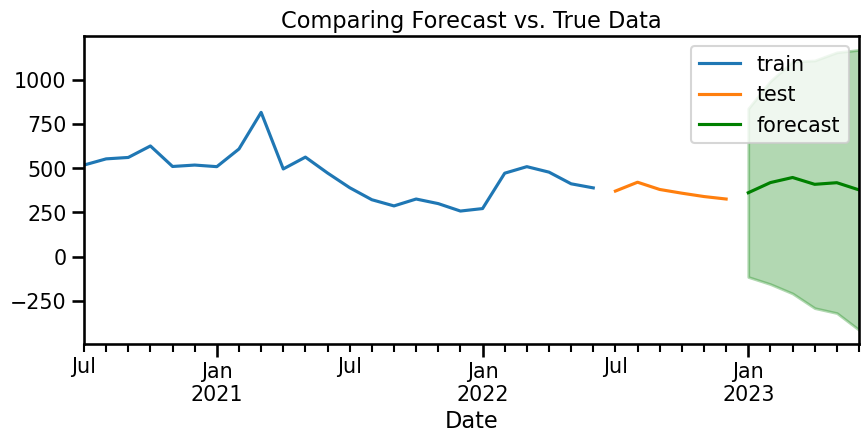

In [162]:
plot_forecast(train, test, final_forecast_narcotics, n_train_lags=24);

# Questions

## Theft

* Calculate the predicted net change in the number (raw counts) of this type of crime from the beginning of the forecast to the end.
* Convert the raw delta into a percent change.

In [181]:
# Define starting and final values
starting_value_theft = final_forecast_theft_predictions['mean'].iloc[0]
final_value_theft = final_forecast_theft_predictions['mean'].iloc[-1]
# Change in x
delta = final_value_theft - starting_value_theft
print(f'The change in X over the forecast is {delta: .2f}.')
perc_change = (delta/starting_value_theft) * 100
print (f'The percentage change is {perc_change :.2f}%.')

starting_value_theft: 4031.377573083103, final_value_theft: 4920.800029002015
The change in X over the forecast is  889.42.
The percentage change is 22.06%.


## Narcotics

* Calculate the predicted net change in the number (raw counts) of this type of crime from the beginning of the forecast to the end.
* Convert the raw delta into a percent change.

In [183]:
# Define starting and final values
starting_value_narc = final_forecast_narcotics['mean'].iloc[0]
final_value_narc = final_forecast_narcotics['mean'].iloc[-1]
# Change in x
delta = final_value_narc - starting_value_narc
print(f'The change in X over the forecast is {delta: .2f}.')
perc_change = (delta/starting_value_narc) * 100
print (f'The percentage change is {perc_change :.2f}%.')

The change in X over the forecast is  16.10.
The percentage change is 4.47%.


# Final Evaluation:

In [166]:
final_forecast_theft_predictions

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-31,4031.377573,321.600839,3401.051512,4661.703634
2023-02-28,3682.882994,406.865671,2885.440932,4480.325055
2023-03-31,4195.646637,485.835925,3243.425722,5147.867552
2023-04-30,4052.230405,551.906011,2970.514501,5133.946309
2023-05-31,4564.098416,611.225543,3366.118365,5762.078467
2023-06-30,4920.800029,665.203413,3617.025297,6224.574761


In [167]:
final_forecast_narcotics

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-31,360.567065,243.039695,-115.781983,836.916113
2023-02-28,417.958113,293.025974,-156.362242,992.278469
2023-03-31,446.728005,334.603071,-209.081963,1102.537973
2023-04-30,408.114661,357.190885,-291.966610,1108.195931
2023-05-31,417.259688,376.092958,-319.868965,1154.388340
2023-06-30,376.668680,403.860703,-414.883751,1168.221112


* Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?
  * Theft
* Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?
    * Theft
* Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?
    Theft

* What recommendation would you make to the stakeholders?
    * I recommend increasing your resources dedicated to theft prevention by 22.06%, starting in January 2023

In [168]:
%%timeit 

my_list = []
for _ in range(1000):
    my_list.append(10 * 10)

68 µs ± 1.33 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [169]:
%%timeit
my_list = [10 * 10 for _ in range(1_000)]

31 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [170]:
import sys

In [171]:
sys.getsizeof(df)

578695770